In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import pandas as pd
import numpy as np
import time
import io
import csv
import string
import os
import sklearn
import matplotlib.pyplot as plt

from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

import seaborn as sns

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation,TimeDistributed,Flatten
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras import layers

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#Filenames
ny_flat_data = '/content/drive/My Drive/ML Data/data_with_features_New_York.csv'
chi_flat_hotel_data = '/content/drive/My Drive/ML Data/chicago_features_hotels.csv'
chi_flat_rest_data = '/content/drive/My Drive/ML Data/chicago_features_restaurants.csv'

In [0]:
#pre_processing for each of the files
ny_data = pd.read_csv(ny_flat_data)

ny_data = ny_data.rename(columns={
    "zipcode": "zip_code", 
    'max_review_per_user_each_day': 'num_review_per_user_each_day',
    'max_review_per_prod_each_day': 'num_review_per_prod_each_day'
    })
ny_data['label'] = ny_data['label'].map({-1: 0, 1: 1})

chi_rest_data = pd.read_csv(chi_flat_rest_data)
chi_rest_data['label'] = chi_rest_data['label'].map({'Y': 1, 'N': 0})
chi_rest_data = chi_rest_data[chi_rest_data.zip_code != "Oops!"]

chi_hotel_data = pd.read_csv(chi_flat_hotel_data)
chi_hotel_data['label'] = chi_hotel_data['label'].map({'Y': 1, 'N': 0})
chi_hotel_data = chi_hotel_data[chi_hotel_data.zip_code != "Oops!"]

/usr/local/lib/python3.6/dist-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


In [0]:
# #helper cell, might need to debugging
# [ ny_data.columns, 
#   chi_hotel_data.columns,
#   chi_rest_data.columns
# ]

In [0]:
#define what we need, you might want to change the preprocessing above if you add new columns here
columns_we_need = [ 'label', 'latitude', 'longitude', 'zip_code', 'review_count', 
                   'review_len', 'review_char', 'punct_count', 'uppercase_count', 'review_per_user',
                   'avg_rating_per_user', 'avg_words_per_user', 'num_review_per_user_each_day', 'review_per_prod',
                   'avg_rating_per_prod', 'avg_words_per_prod', 'num_review_per_prod_each_day']

#['date', 'user_id', 'prod_id']                   

In [0]:
#prune the columns
ny_data        = ny_data[columns_we_need]
chi_hotel_data = chi_hotel_data[columns_we_need]
chi_rest_data  = chi_rest_data[columns_we_need]

In [0]:
#merge data
full_data_raw = pd.concat([ny_data, chi_hotel_data, chi_rest_data])

In [0]:
#Data balancing

# Separate majority and minority classes
df_majority = full_data_raw[full_data_raw.label==1]
df_minority = full_data_raw[full_data_raw.label==0]
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=330482,    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled.label.value_counts()

full_data = df_upsampled

In [0]:
#Splitting and scaling the data into train and test
data_features = full_data.drop('label', axis=1)
sc = StandardScaler()
data_features_scaled = sc.fit_transform(data_features)
labels = full_data["label"]
X_train, X_test, y_train, y_test = train_test_split(data_features, labels, test_size=0.25)

In [0]:
model = LogisticRegression(penalty='l2',  tol=0.00001, fit_intercept=True, intercept_scaling=1, solver='lbfgs', max_iter = 10000).fit(X_train, y_train)

In [0]:
y_pred = model.predict(X_test)

In [0]:
#ROC Analysis for train data
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test, y_pred, drop_intermediate=True)
auc = sklearn.metrics.roc_auc_score(y_test, y_pred)

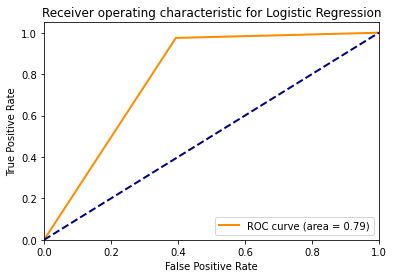

In [0]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for Logistic Regression')
plt.legend(loc="lower right")
plt.show()

In [0]:
threshold = 0.4

y_pred_threshold = [1 if i > threshold else 0 for i in y_pred]

In [0]:
print(sklearn.metrics.classification_report(y_test, y_pred_threshold))

              precision    recall  f1-score   support

           0       0.96      0.61      0.74     82620
           1       0.71      0.97      0.82     82621

    accuracy                           0.79    165241
   macro avg       0.84      0.79      0.78    165241
weighted avg       0.84      0.79      0.78    165241



Text(0.5, 257.44, 'Predicted label')

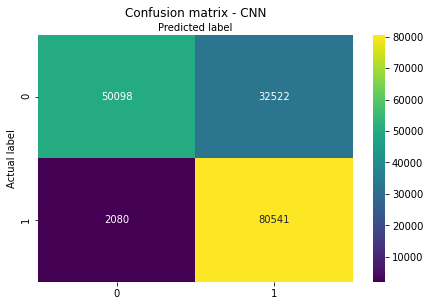

In [0]:
class_names=["True","False"]
cnf_matrix = sklearn.metrics.confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="viridis" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix - CNN', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')